# Настройки 2,3 обучения нейронных сетей в `PyTorch`

<!-- [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1k5ih-FSbCTuErwBHHi3J3uCN1q4fRzFI) -->

Как правило, обучение моделей в `PyTorch` — это продолжительный процесс, который требует достаточно много усилий. Эти усилия на этапе аналитики сосредотачиваются на подготовке данных и экспериментировании с моделью нейронной сети и ее обучением.

Как будет показано позже, часто среди моделей машинного обучения выбираются готовые модели, которые используются как некоторая основа. Часто эти модели предобучены. Однако качество предобученной модели на целевом наборе данных, как правило, неудовлетворительное. Поэтому модели в любом случае надо доучивать.

Ниже приведен [один из примеров последовательности](https://www.learnpytorch.io/01_pytorch_workflow/#what-were-going-to-cover), которая соответствует общему порядку экспериментов с нейронной сетью.  Текущая практика посвящена вопросу обучения нейронной сети во многих аспектах этого `workflow`.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01_a_pytorch_workflow.png" width="900px">

Важно:
* также иметь в виду вопросы ускорения и вычислительной оптимизации обучения нейронных сетей, см., например, [тут](https://habr.com/ru/companies/wunderfund/articles/820721/) и для [`CPU` тут](https://habr.com/ru/companies/ruvds/articles/822711/). 
* И учитывать вопросы логирования результатов экспериментов, см., например, [тут](https://www.learnpytorch.io/07_pytorch_experiment_tracking/).

В данных практиках будут рассмотрены некоторые приемы улучшения работы нейронных сетей. Вообще говоря таких приемов может быть предложено достаточно много. Большенство этих приемов эвристические и требует экспериментальной проверки в конкретных условиях.

* [A Recipe for Training Neural Networks](https://karpathy.github.io/2019/04/25/recipe/) от Анедрея Карпатых.
* [Bag of Tricks for Image Classification with Convolutional Neural Networks](https://arxiv.org/abs/1812.01187) - статья 2018 год об обучении сверточных нейронных сетей
* [Tips for Model Training](https://docs.ultralytics.com/guides/model-training-tips/#community-resources) от известной команды `ultralytics` и другие гайд от них и других команд. 
* и в других тематических публикациях известных специалистов, например [тут](https://sebastianraschka.com/blog/2023/pytorch-faster.html), [тут](https://github.com/vahidk/EffectivePyTorch), [тут](https://github.com/rasbt/deeplearning-models)  а также официальные публикации `PyTorch`, [например](https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html), и известные коллекции примеров, [например](https://madewithml.com/) или [тут](https://github.com/Conchylicultor/Deep-Learning-Tricks). 
<!-- и [тут](https://stackoverflow.com/questions/70554413/how-to-improve-the-performance-of-cnn-model-for-a-specific-dataset-getting-low). -->
* Важно также иметь в виду вопросы ускорения и вычислительной оптимизации обучения нейронных сетей, см., [например](https://habr.com/ru/companies/wunderfund/articles/820721/).
* А также важно иметь в виду вопросы настройки гиперпараметров обучения нейронных сетей, см., [например](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html) и [тут](https://docs.ray.io/en/latest/tune/getting-started.html) и [тут](https://docs.ray.io/en/latest/tune/examples/tune-pytorch-cifar.html).
 

## Импорт `torch`

In [20]:
import random
import os
import copy
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

In [3]:
import torchvision
from torchvision import transforms, datasets
import torchvision.transforms as T

In [4]:
from torchinfo import summary
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tqdm.notebook import tqdm, trange

Настроим работу с `PyTorch`. Выберем формат работы и устройство для работы.

In [5]:
def torch_stats(): 
    torch_version = ".".join(torch.__version__.split(".")[:2])
    print('torch version:',torch_version)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    dtype = torch.float32
    
    if device.type == 'cuda':
        cuda_version  = torch.__version__.split("+")[-1]
        print("cuda: ", cuda_version)
        
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        print('Cuda is available:',torch.cuda.is_available())

        n_devices = torch.cuda.device_count()
        print('number of devices: %d'%(n_devices))

        for cnt_device in range(n_devices):
            print(torch.cuda.get_device_name(cnt_device))
            print('Memory Usage:')
            print('Allocated:', round(torch.cuda.memory_allocated(cnt_device)/1024**3,1), 'GB')
            print('Cached:   ', round(torch.cuda.memory_reserved(cnt_device)/1024**3,1), 'GB')


    torch.set_default_dtype(dtype) # float32
    print('default data type:',dtype)
    
    num_workers=os.cpu_count()
    print ('available number of workers:',num_workers)
    
    return device, dtype, num_workers
#-------------------------------
def torch_seed(seed = 42, deterministic = True):
    random.seed(seed) # random and transforms
    np.random.seed(seed) #numpy
    torch.manual_seed(seed) #cpu
    torch.cuda.manual_seed(seed) #gpu
    torch.backends.cudnn.deterministic=deterministic #cudnn 
    torch.backends.cudnn.benchmark = False

In [6]:
device, dtype, num_workers = torch_stats()
torch_seed(seed = 42, deterministic = True)

torch version: 2.3
Using device: cpu
default data type: torch.float32
available number of workers: 4


## Набор данных

### Загрузка преобразований данных `test_data.classes`

Рассмотрим набор данных [`FashionMNIST`](https://pytorch.org/vision/0.18/generated/torchvision.datasets.FashionMNIST.html), который в этот раз импортируется из пакета `torchvision.datasets`.

При загрузке набора данных задаются стандартные преобразования `transforms`.

* Минимальное преобразование, которое необходимо произвести, — это преобразовать входные данные в тензор. 
* В нашем случае мы также проведем преобразование входного изображения в вектор. Изображения в наборе данных имеют размер $28\times 28$, это значит, что в результате преобразований будет тензор, имеющий $28\cdot 28 = 784$ значения. 
* Также проведем нормализацию входного тензора в диапазон $[0, 1]$. Мы знаем, что входные данные представляют собой бинарное изображение, где максимальное значение — `255`, а минимальное — `0`. Поэтому нормировку мы проведем при помощи деления на `255`.
* `PyTorch` позволяет производить преобразования входных данных при помощи класса `transforms.Compose`. Объект этого класса позволяет описывать последовательность преобразований над входными данными, указывая их в виде списка.

Объект `transform` класса `transforms.Compose` будет передан в соответствующем аргументе в загрузчик данных нашего датасета.


В дополнение к указанным выше преобразованиям попробуем включить следующие:

* __Для тестовой выборки__:
    * Нормализация данных `Normalize` вместо ручной нормализации,
    * Использования `Lambda` функции для операции `flatten`,
    * Преобразование типа данных `ConvertImageDtype`
* __Для тренировочной выборки__:
    * К преобразованиям добавлены два типа аугментации: 
        * `RandomRotation` - поворот изображения.
        * `RandomVerticalFlip` - случайный переворот изображения.

In [39]:
test_transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = 0.5, std = 0.5),
                           transforms.Lambda(lambda x: torch.flatten(x)),
                           transforms.ConvertImageDtype(torch.float), 
                            ])

train_transform = transforms.Compose([
                            transforms.RandomRotation(10),
                            transforms.RandomVerticalFlip(),
                            *test_transform.transforms
                            ])
train_transform

Compose(
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    RandomVerticalFlip(p=0.5)
    ToTensor()
    Normalize(mean=0.5, std=0.5)
    Lambda()
    ConvertImageDtype()
)

### Загрузка набора данных из модуля `datasets`

 Тренировочная часть и тестовая часть загружаются отдельно.

In [40]:
# import ssl
# ssl._create_default_https_context = ssl._create_stdlib_context

In [41]:
train_data = datasets.FashionMNIST('data', train=True,  download=True, transform=train_transform)
test_data  = datasets.FashionMNIST('data', train=False, download=True, transform=test_transform )

In [42]:
test_data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Полученный набор данных представляет собой итерируемый объект. 

Доступ к отдельным элементам такого датасета может быть получен как для списка. 

Каждый элемент представляет собой изображение (в нашем случае — вектор) и его метку.

In [43]:
train_data[0][0].shape, train_data[0][1] 

(torch.Size([784]), 9)

Зададимся именами классов.

In [44]:
name_classes = test_data.classes
#['T-Shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']

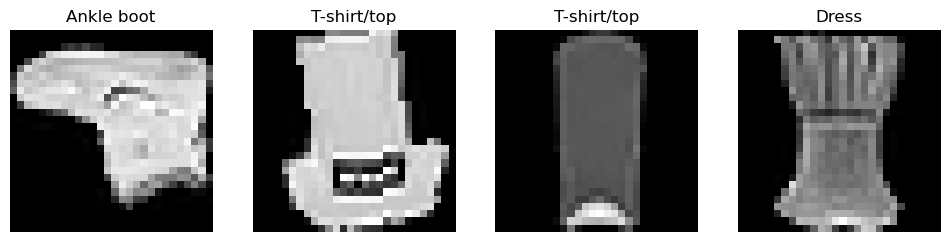

In [45]:
WIDTH = 28
HEIGH = 28

n_imgs = 4

fig, axs = plt.subplots(1,n_imgs,figsize=(12,3));
for i,ax in enumerate(axs):
    im = train_data[i]
    ax.imshow(im[0].view(WIDTH,HEIGH), cmap='gray'); 
    ax.set_title(name_classes[im[1]]); 
    ax.axis('off')
plt.show()

Соотвественно можно узнать размер выборок

In [46]:
len(train_data), len(test_data)

(60000, 10000)

### Выбор валидационной подвыборки

Набор данных имеет только тренировочную часть и тестовую часть. Однако нам также понадобиться валидационная часть, которую можно выделить из тренировочной. 
 
Для выделения валидационного набора используем утилиту `random_split` из `torch.utils.data`. 

<blockquote> 
Отметим, что могут быть и другие способы сплита данных.
    
<details>    
    
```python
    from torch.utils.data import SubsetRandomSampler
    indices=np.arange(len(train))
    np.random.shuffle(indices)
    
    split=int(np.floor(valid_size*len(train)))
    train_idx = indices[split:]
    valid_idx = indices[:split]
    
    train_sampler=SubsetRandomSampler(train_idx)
    valid_sampler=SubsetRandomSampler(valid_idx)
    
    
    train_loader=torch.utils.data.DataLoader(train_data, batch_size=batch_size,  
                                             sampler=train_sampler, num_workers=num_workers)
    valid_loader=torch.utils.data.DataLoader(train_data, batch_size=batch_size,  
                                             sampler=train_sampler, shuffle=False, num_workers=num_workers)
    test_loader =torch.utils.data.DataLoader(test_data,  batch_size=batch_size, 
                                             shuffle=False,  num_workers=num_workers)

```

</blockquote>

In [47]:
TRAIN_RATIO = 0.8

g = torch.Generator(device=device).manual_seed(42)

n_train_examples = int(len(train_data) * TRAIN_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = torch.utils.data.random_split(train_data, [n_train_examples, n_valid_examples], generator=g)

print(f"Training data size : {len(train_data)}, Validation data size : {len(valid_data)}, Test data size : {len(test_data)}")

Training data size : 48000, Validation data size : 12000, Test data size : 10000


Теперь получены три набора данных: валидационный, тренировочный и тестовый. <br>
__Важно__ также отметить, что если тренировочные данные используются с аугментацией, то валидационный набор данных лучше использовать без аугментации. Ниже показан пример того как это можно сделать.

```python
    valid_data = copy.deepcopy(valid_data)
    valid_data.dataset.transform = test_transforms
```




In [49]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transform

## Загрузчик пакетов данных

После загрузки изображений в формате `pytorch` необходимо автоматизировать генерацию минибатчей, по которым будет производиться обучение. 

Желательно производить загрузку батчей динамически/стохастически. Другими словами, во время каждой эпохи обучения мы будем вызывать необходимое количество таких батчей, каждый из которых будет представлять собой заданное количество примеров входных данных, выбранных случайно из последовательности.

Для осуществления указанного кода воспользуемся утилитой `DataLoader` из `torch.utils.data`. Пример реализации показан ниже.

In [53]:
BATCH_SIZE = 64

g = torch.Generator(device=device).manual_seed(42)

train_loader = data.DataLoader(train_data,
                                 shuffle=True,
                                 generator= g, 
                                 batch_size=BATCH_SIZE)

val_loader = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_loader = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

 
print(f"Training data batches : {len(train_loader)}, Validation data batches : {len(val_loader)}, Test data batches : {len(test_loader)}")

Training data batches : 750, Validation data batches : 188, Test data batches : 157


Проверим размер каждого батча.

In [54]:
images, _ =  next(iter(train_loader))
images.shape

torch.Size([64, 784])

Проведем визуализацию батча. Для этого в `torchvision` предусмотрена специальная функция `make_grid`.
<!-- 
Обратите внимание на порядок операций в примере с визуализацией. Сначала производится преобразование размеров батча. Из размеров $[64, 784]$, означающих $64$ вектора, каждый по $784$ значения, мы получаем 64 изображения, каждое размером $28\times 28$.\
Однако также мы добавляем дополнительную пустую размерность. То есть вместо того, чтобы получить массив $[64, 28, 28]$, мы получаем размер $[64, 1, 28, 28]$. Дополнительная размерность означает канал изображения. В нашем случае канал только $1$. Однако в более продвинутых задачах анализа изображений мы будем использовать и по $3$ канала.\
Аналогично, и в нашем случае для визуализации батч будет создан с $3$ каналами. Поскольку мы формируем изображение, где по горизонтали должно уместиться 8 изображений, то размер будет $[3, 28\cdot 8, 28\cdot 8] = [3, 224, 224]$.

Также важно отметить, что после получения батча мы проводим операцию `transpose((1, 2, 0))` — то есть каналы становятся `3`-й размерностью, а не `1`-й. Тут имеет место крайне важное различие между представлением данных в `matplotlib` и `torch`. В `matplotlib` каналы — это последняя размерность. Тогда как в `torch` каналы — это или `1`-я размерность, или `2`-я, если речь идет о наборе изображений (батче). -->

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


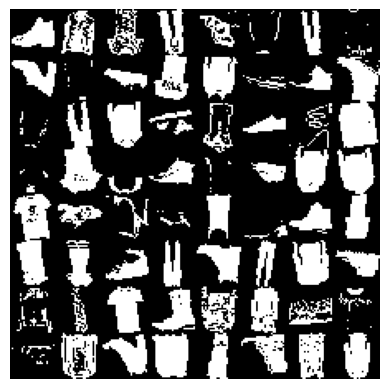

(torch.Size([64, 1, 28, 28]), torch.Size([3, 224, 224]), (224, 224, 3))

In [55]:
images = images.reshape(-1,1,28,28)
batch = torchvision.utils.make_grid(images, nrow = int(np.sqrt(images.shape[0])), padding = 0)
vis_batch = batch.data.numpy().transpose((1, 2, 0))*255
plt.imshow(vis_batch); 
plt.axis('off');
plt.show()
images.shape, batch.shape,  vis_batch.shape


## Описание полносвязной сети

### Описание модели в классовом стиле

В качестве базовой архитектуры выбирем некоторую модификацию [линейного блока](https://github.com/godofpdog/ViT_PyTorch/blob/main/vit_pytorch/modules.py) с использованием функций активации GeLU и  использованием нормализации слоя.

In [60]:
IMAGE_WIDTH = 28 
IMAGE_HEIGH = 28

class Model(nn.Module):
    def __init__(self):
        super().__init__()        
        self.embedding = nn.Linear(IMAGE_WIDTH*IMAGE_HEIGH, 64)
                
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc_out = nn.Linear(64, 10)
        
        self.ln1  = nn.LayerNorm(64)
        self.ln2  = nn.LayerNorm(128)
        self.ln3  = nn.LayerNorm(128)

    def forward(self, x):
        x = self.embedding(x)
        shortcut = x       
        
        x = F.gelu(self.fc1(self.ln1(x)))
        x = F.gelu(self.fc2(self.ln2(x)))
        x = F.gelu(self.fc3(self.ln3(x)))

        return self.fc_out(x + shortcut) 

Также важно уточнить, что в указанных структурах могут быть заданы не только полные модели, но и их [отдельные слои](https://github.com/Devinterview-io/pytorch-interview-questions?tab=readme-ov-file#process-for-implementing-custom-layers).

Проверим результат.

In [61]:
model = Model()

summary(model,input_size =(1,784))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [1, 10]                   --
├─Linear: 1-1                            [1, 64]                   50,240
├─LayerNorm: 1-2                         [1, 64]                   128
├─Linear: 1-3                            [1, 128]                  8,320
├─LayerNorm: 1-4                         [1, 128]                  256
├─Linear: 1-5                            [1, 128]                  16,512
├─LayerNorm: 1-6                         [1, 128]                  256
├─Linear: 1-7                            [1, 64]                   8,256
├─Linear: 1-8                            [1, 10]                   650
Total params: 84,618
Trainable params: 84,618
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.08
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.34
Estimated Total Size (MB): 0.35

### Выбор оптимизатора и функции потерь

Как и прежде, используем алгоритм `Adam` с параметрами по умолчанию для обновления нашей модели. Улучшенные результаты можно получить, перебирая различные оптимизаторы и скорости обучения, однако стандартный `Adam` обычно является хорошей отправной точкой. 

In [63]:
optimizer = optim.AdamW(model.parameters(), lr = 3e-4)

Аналогично предыдущим занятиям зададимся функцией потерь `CrossEntropyLoss`.

In [64]:
criterion = nn.CrossEntropyLoss() #This criterion assume built-in `log_softmax` 

Отметим, что на самом деле, если используется `GPU` в качестве вычислителя, то следует отправить и функцию потерь и модель на устройство.

In [65]:
model = model.to(device)
criterion = criterion.to(device)

Если для обучения моделей используют несколько `GPU`, то доступен параллелилизм

<details>

> Если для обучения моделей используют несколько GPU, то самым простым подходом в этой ситуации будет применение класса `DistributedDataParallel` (`DDP`). В результате будут созданы несколько идентичных процессов, а градиенты будут агрегироваться на шаге обратного прохода. <br>
> Также [может быть использован](https://habr.com/ru/companies/wunderfund/articles/820721/) `Fully Sharded Data Parallel` (`FSDP`, параллелизм с полным шардингом данных). В этом режиме данные асинхронно распределяются между `GPU` вместо того чтобы запускать код на каждом `GPU` с одинаковыми моделями и с одинаковыми состояниями оптимизатора.
> `from torch.distributed.fsdp import FullyShardedDataParallel as FSDP` и `model = FSDP(model)`
    
>Для более подробного исследования производительности модели рекомендуется использование профайлера https://pytorch.org/blog/introducing-pytorch-profiler-the-new-and-improved-performance-tool/.    

Также напомним, что в версии `PyTorch 2.x` доступен способ ускорения модели при помощи ее компиляции [`torch.compile`](https://pytorch.org/docs/stable/generated/torch.compile.html). [В этом режиме](https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html) вычислительный граф модели собирается при первом проходе по ней вместо того, чтобы вычисляться динамический каждый раз.

Отметим, что на сегодня `torch.compile` работает не на всех платформах.

In [66]:
from sys import platform
if platform == "linux" or platform == "linux2":
    model = torch.compile(model)

### Метрика 

Также создадим отдельную функцию для расчета точности модели.

In [67]:
def calculate_accuracy(y_pred, y):
    with torch.no_grad():
        top_pred = y_pred.argmax(1, keepdim=True)
        correct = top_pred.eq(y.view_as(top_pred)).sum()
        acc = correct.float() / y.shape[0]
    return acc

metric = calculate_accuracy

### Инициализация модели для ее тренирвоки

Объеденим предыдущие шаги вместе

In [68]:
model = Model()
criterion = nn.CrossEntropyLoss()
model = model.to(device)
criterion = criterion.to(device)
optimizer = optim.Adam(model.parameters())

metric = calculate_accuracy

## Функции для обучения и работы

### Функция тренировки `train`

Перед началом тренировки запишем функцию `train`, которая должна реализовывать тренировку в рамках 1 эпохи. 

Функция будет выбирать все батчи из dataloader в формате `x` — данные и `y` — ответы. Затем для каждого батча будет производится расчет выхода модели `model.forward(x)` и расчет параметров `loss` (потери) и `acc` (точность). 

Функция имеет следующую последовательность действий:
- перевод модели в режим обучения (`model.train()`).
- перебор загрузчика данных, возвращая `batch`.
- размещение д"анных на `GPU`, если есть.
- очистка градиента `zero_grad(set_to_none = True)`.
- передача пакета изображений `x` в модель, чтобы получить предсказания `y_pred`.
- вычисление функции потерь между предсказаниями и фактическими метками.
- вычисление точности между предсказаниями и реальными метками.
- вычисление градиента каждого параметра.
- обновление параметров, выполнив шаг оптимизатора.
- обновление метрики.

*Отметим* 
* В режиме тренировки модель должна иметь директиву train `model.train()`, которая необходима в ряде элементов (например, batchnorm), имеющих разное поведение при тренировке и эксплуатации.

* Также отметим, что `dataloader` вызывается при помощи `tqdm` — то есть т. н. *progress bar*.

In [69]:
def train(model, dataloader, optimizer, criterion, metric,  device):

    epoch_loss = 0
    epoch_acc  = 0

    model.train()

    for (x, y) in tqdm(dataloader, desc="Training", leave=False):

        x, y = x.to(device), y.to(device)

        optimizer.zero_grad(set_to_none = True)

        y_pred = model(x)

        loss = criterion(y_pred, y)
        acc  = metric(y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

### Функция текущей проверки точности `evaluate` (для валидации)

Аналогично создадим функцию `evaluate`, которая позволяет оценивать работу модели, например, для валидационного или тестового наборов данных. Особенностями этой функции будут директива `model.eval()` и `torch.inference_mode()`, которые необходимы в режиме тестирования нейронной сети.
<!-- 
`torch.no_grad()` гарантирует, что градиенты не будут вычисляться для всего, что находится внутри блока `with`. Поскольку нашей модели не придется вычислять градиенты, она будет работать быстрее и использовать меньше памяти.  -->

In [70]:
def evaluate(model, dataloader, criterion, metric, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.eval()

    with torch.inference_mode():
        
        for (x, y) in tqdm(dataloader, desc="Evaluating", leave=False):

            x, y = x.to(device), y.to(device)

            y_pred = model.forward(x)

            loss = criterion(y_pred, y)
            acc  = metric( y_pred, y)

            epoch_loss += loss.item()
            epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

### Оценка времени эпохи

Запишем вспомогательную функцию расчета времени.

In [71]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Функция обучения (`fit`).

Итоговый процесс обучения будет состоять из процедур тренировки и оценки для каждой эпохи. Также будет оцениваться время работы каждой эпохи.

В процедуру включена проверка модели на лучшее значение метрики на валидации. Лучшая метрика сохраняется. Точнее, сохраняются ее параметры `model.state_dict()`.

In [72]:
EPOCHS = 10

def fit(model, train_loader, val_loader, optimizer, criterion, metric, epochs = EPOCHS, device='cpu',  path_best = 'best_model.pt', verbose = True):

   
    best_valid_loss = float('inf')

    for epoch in trange(epochs):

        start_time = time.monotonic()

        train_loss, train_acc = train(model, train_loader, optimizer, criterion, metric, device)
        valid_loss, valid_acc = evaluate(model, val_loader, criterion, metric, device)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), path_best)

        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if verbose == True:
            print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
            print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%',
            f' | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%') 


Теперь вместо того, чтобы останавливаться на последней эпохе, выберем лучшую эпоху и загрузим ее значения. 

Проверим точность модели на тестовых данных.

In [73]:
fit(model, train_loader, val_loader, optimizer, criterion, metric, epochs = EPOCHS, device='cpu', verbose = True)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 51s
	Train Loss: 0.680 | Train Acc: 74.70%  | Val. Loss: 0.577 | Val. Acc: 78.72%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 46s
	Train Loss: 0.551 | Train Acc: 79.50%  | Val. Loss: 0.520 | Val. Acc: 80.88%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 36s
	Train Loss: 0.513 | Train Acc: 81.10%  | Val. Loss: 0.491 | Val. Acc: 81.82%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 36s
	Train Loss: 0.482 | Train Acc: 82.39%  | Val. Loss: 0.440 | Val. Acc: 83.98%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 37s
	Train Loss: 0.461 | Train Acc: 82.98%  | Val. Loss: 0.439 | Val. Acc: 83.89%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 35s
	Train Loss: 0.442 | Train Acc: 83.91%  | Val. Loss: 0.437 | Val. Acc: 84.33%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 41s
	Train Loss: 0.432 | Train Acc: 83.89%  | Val. Loss: 0.425 | Val. Acc: 84.48%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 32s
	Train Loss: 0.418 | Train Acc: 84.47%  | Val. Loss: 0.429 | Val. Acc: 84.30%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 22s
	Train Loss: 0.409 | Train Acc: 84.88%  | Val. Loss: 0.404 | Val. Acc: 85.53%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 22s
	Train Loss: 0.401 | Train Acc: 85.21%  | Val. Loss: 0.399 | Val. Acc: 85.84%


In [74]:
model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

In [75]:
test_loss, test_acc = evaluate(model, test_loader, criterion, metric, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.418 | Test Acc: 85.09%


## Задание

__1.__ Предлагается дополнить архиектуру модулем Дропаут в верной последовательности.

__2.__ Предлагается протестировать гипотезу о замене операции нормализации слоя на операцию батч-нормализации.

<code style="color : red">__3.*__</code> Предлагается также модифицировать архитектуру в виде, например, т.н. `gated MLP`  c использованием операций `split` и конкотенация ($U$), или  [с использованием операции умножения вместо конкатенации](https://paperswithcode.com/method/gmlp) по анологии как это [показано ниже](https://wandb.ai/sauravmaheshkar/gMLP/reports/Bringing-Back-MLPs--Vmlldzo4MTM1NTc):

<img  src="https://api.wandb.ai/files/sauravmaheshkar/images/projects/363173/34ad825e.png" width="500px">

# Приемы обучения НС

## Инициализация обучения

Для повышения качества работы с моделями проведем инициализацию весовых параметров при помощи модуля [`nn.init`](https://pytorch.org/docs/stable/nn.init.html).

> Отметим, что в ряде случаев достаточно инициализации «по умолчанию». В других случаях лучше проводить рекомендованные схемы инициализации. Однако, пробуя вручную различные схемы инициализации, мы обычно можем добиться небольшого улучшения производительности.

Инициализируем параметры, создавая функцию, которая принимает модуль (слой) модели, проверяет, какого типа этот слой, а затем использует методы `nn.init` для инициализации параметров рекомендуемым способом.

В достаточно общем случае можно сказать, что инициализация имеет вид нормального или равномерного распределений с параметром (стандартным отклонением или разбросом), заданным:

$$\frac{\text{gain}}{\sqrt{\text{fan mode}}}$$

Значение $\text{gain}$ зависит от нелинейности, которая будет использована после слоя. Например, `ReLU` устанавливает $\text{gain}$ в $\sqrt{2}$. Значение $\text{fan mode}$ может быть либо `fan_in`, либо `fan_out`. `fan_in` — это количество соединений, входящих в слой, а `fan_out` — количество соединений, выходящих из слоя. Количество соединений — это количество параметров (оно есть не только у полносвязного слоя, но и у остальных слоев). Для линейного слоя можно записать названную инициализацию как $$\frac{\text{2}}{\sqrt{\text{fan in}+\text{fan out}}}$$     
> Например, для сверточного слоя на вход поступает фильтр 3x3x3, поэтому `fan_in` равно 27, а на выход — 64x3x3, поэтому `fan_out` равно 576. Эта схема инициализации называется *Kaiming Normal*, также известная как *Xe Normal*.

В `nn.init` есть функция `calculate_gain`, которая рассчитывает $\text{gain}$ для заданных функций активации.

При инициализации — инициализируем члены смещения нулями.

> Зачем вообще нужно инициализировать параметры? Мы хотим, чтобы выходы каждой функции активации (и, следовательно, входы последующего слоя) имели среднее значение 0 и стандартное отклонение 1. Тогда выход производной функций активации будет максимальным, а значения весов не приведет к вымыванию или взрыву градиента.

Подробней о рекомендациях инициализации смотрите [в документации](https://pytorch.org/docs/stable/nn.init.html).

In [76]:
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

Применим инициализацию с помощью метода модели `apply`. Это вызовет заданную функцию на каждом модуле и подмодуле в модели.  

In [77]:
model.apply(initialize_parameters)

Model(
  (embedding): Linear(in_features=784, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc_out): Linear(in_features=64, out_features=10, bias=True)
  (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (ln3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
)

> Смотрите также примеры визуализации весовых параметров [при различных стратегиях инициализации](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial4/Optimization_and_Initialization.html?highlight=initialization) и [тут](https://www.deeplearning.ai/ai-notes/initialization/index.html).

## Поиск диапазона скоростей обучения

Проведем поиск оптимальной скорости обучения. 
Для этого используем готовую утилиту [pytorch-lr-finder](https://github.com/davidtvs/pytorch-lr-finder). 
<!-- Код здесь взят из урезанной и слегка модифицированной версии  [pytorch-lr-finder](https://github.com/davidtvs/pytorch-lr-finder).
```python
from torch.optim.lr_scheduler import _LRScheduler

class LRFinder:
    def __init__(self, model, optimizer, criterion, device):

        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device

        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr=10, num_iter=100,
                   smooth_f=0.05, diverge_th=5):

        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)

        iterator = IteratorWrapper(iterator)

        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            lrs.append(lr_scheduler.get_last_lr()[0])

            # update lr
            lr_scheduler.step()

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]

            if loss < best_loss:
                best_loss = loss

            losses.append(loss)

            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break

        # reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))

        return lrs, losses

    def _train_batch(self, iterator):

        self.model.train()

        self.optimizer.zero_grad()

        x, y = iterator.get_batch()

        x = x.to(self.device)
        y = y.to(self.device)

        y_pred = self.model(x)

        loss = self.criterion(y_pred, y)

        loss.backward()

        self.optimizer.step()

        return loss.item()


class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r
                for base_lr in self.base_lrs]


class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

def plot_lr_finder(lrs, losses, skip_start=5, skip_end=5):

    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]

    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

    best_lr = lrs[np.argmin(losses)]

    print(f'Best lr = {best_lr:.5f}')

    return best_lr

best_lr = plot_lr_finder(lrs, losses)
``` -->

**Примечание**: поиск скорости обучения — это скорее искусство, чем наука. Алгоритм не сможет найти точную скорость обучения с точностью до $5$ знаков после запятой, которая всегда будет давать нам $100\%$ точность — но обычно это будет лучше, чем просто выбрать скорость обучения из воздуха.  

Наиболее часто используемый оптимизатор — `Adam`. Скорость обучения `Adam` по умолчанию обычно является отличным выбором, но, подобно тому, как вручную инициализировали параметры, чтобы потенциально получить некоторое улучшение производительности, мы можем попытаться рассчитать оптимальную скорость обучения вручную.  

Как работает система поиска скорости обучения? В алгоритм `finder` подается модель, оптимизатор и критерий, который хотелось бы использовать. Оптимизатору задается скорость обучения с гораздо меньше, чем предполагается использовать. Затем обучаются модели на данных из обучающего набора — вычисляются потери и обновляются параметры. После каждой партии экспоненциально увеличивается скорость обучения. Так делается вплоть до заданного верхнего предела. Это повторяется до тех пор, пока значения функции потерь не начинают расходится более чем в 5 раз по сравнению с наилучшими потерями или пока не достигнута максимальная скорость обучения.  

Вычисленные функции потерь обычно довольно шумные, поэтому сохраняется экспоненциальное среднее значений по батчам.  

При настоящем обучении необходимо использовать инициализированные параметры, а не те, которые были обновлены в результате поиска скорости обучения. Поэтому сохраним параметры модели на диск при инициализации алгоритма поиска, а затем сбросим их на желаемые инициализированные параметры непосредственно перед возвратом функции `range_test`, загружая начальные значения с диска.

Сначала создается экземпляр класса `finder` с моделью, оптимизатором и функцией потерь. Затем мы используем `range_test` с обучающим итератором, максимальной скоростью обучения и количеством итераций, которые мы хотим использовать. 

In [78]:
# !pip3 install torch_lr_finder
from torch_lr_finder import LRFinder

C:\Users\Ronkin\anaconda3\Lib\site-packages\torch_lr_finder\lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.03E-04


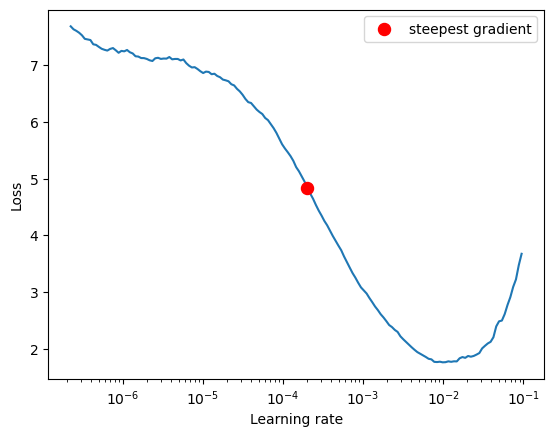

In [87]:
START_LR = 1e-7
model = Model()
model.apply(initialize_parameters)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)


optimizer = optim.AdamW(model.parameters(), lr=START_LR)
lr_finder = LRFinder(model, optimizer, criterion)
lr_finder.range_test(train_loader, end_lr=1, num_iter=200)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state


Проверим точность для найденной скорости обучения. Отметим, что найденная скорость - это скорее правильный порядок скорости обучения, нежели чем точное значение. В данном случае порядок можно оценить как $0.0002 - 0.01$.

In [90]:
model = Model()
model.apply(initialize_parameters)
model = model.to(device)
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0002)

In [91]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, metric, device)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, metric, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%',
    f'| Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 24s
	Train Loss: 0.984 | Train Acc: 66.84% | Val. Loss: 0.677 | Val. Acc: 75.74%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 25s
	Train Loss: 0.635 | Train Acc: 77.07% | Val. Loss: 0.569 | Val. Acc: 79.70%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 26s
	Train Loss: 0.569 | Train Acc: 79.49% | Val. Loss: 0.510 | Val. Acc: 81.96%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 25s
	Train Loss: 0.529 | Train Acc: 81.06% | Val. Loss: 0.500 | Val. Acc: 82.16%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 26s
	Train Loss: 0.496 | Train Acc: 82.10% | Val. Loss: 0.467 | Val. Acc: 83.49%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [102]:
model.load_state_dict(torch.load('best_model.pt'))

test_loss, test_acc = evaluate(model, test_loader, criterion, metric, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.496 | Test Acc: 82.40%


## Разделение модели на блоки и управление ими

В ряде случаев более удобным является описание модели в виде блоков или других составных частей, стыкуемых вместе. Например, ниже показана модель, переписанная в виде двух составных частей: кодировщика признаков `feature_extractor` и слоя принятия решений `fc`. В таком виде моделью проще управлять.

In [28]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(nn.Linear(IMAGE_WIDTH*IMAGE_HEIGH, 64),
                                              nn.ReLU(), 
                                              nn.Linear(64, 64),
                                              nn.ReLU(),)
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.fc(x)
        return x   
model = Model()
model

Model(
  (feature_extractor): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (fc): Linear(in_features=64, out_features=10, bias=True)
)

Например, можно отдельно вызвать `feature_extractor`.

In [29]:
model.feature_extractor

Sequential(
  (0): Linear(in_features=784, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
)

Или можно отдельно получить результат работы модели.

In [30]:
x,y = next(iter(train_loader))
with torch.inference_mode():
    model.eval(); 
    fe = model.feature_extractor(x)
    head =  model.fc(fe)     
    print(fe.shape, head.shape)

torch.Size([64, 64]) torch.Size([64, 10])


> Отметим, что теперь можно скомбинировать полученный `feature_extractor` c новой головной частью модели.
>```python
    m2 = nn.Sequential(model.feature_extractor, nn.Linear(64,32), nn.ReLU(), nn.Linear(32,10))
```

## Оптимизация параметров обучения по блокам

При обучении моделей часто оказывается желательным проведение [настройки параметров обучения](https://pytorch.org/docs/stable/optim.html#module-torch.optim).
Например, в ряде случаев полезным оказывается использование отдельных параметров обучения для экстрактора признаков и его головной части. Этот прием будет еще упомянут в разделе перенос признаков. Тут, однако, тоже его отметим. Прием использования различных скоростей обучения позволяет регулировать интенсивность обучения. Например, если мы ожидаем, что часть нейронной сети предобучена, то для нее скорость обучения должна быть гораздо ниже (если предобученные слои вообще нуждаются в обучении). 

> Часто при использовании предобученных сетей используется гипотеза заключается в том, что ранние слои нейронной сети учатся извлекать более общие признаки, в то время как поздние слои учатся извлекать более специфичные для конкретной задачи признаки. Если это так, то общие признаки, извлекаемые ранними слоями, должны быть полезны для любой задачи, и мы должны изменять их предварительно обученные веса на очень небольшую величину — если вообще должны.

> Дискриминативную тонкую настройку параметров обучения обычно нет необходимости использовать при обучении модели на основе случайно инициализированных весов.


In [31]:
model = Model()
model.apply(initialize_parameters)
model = model.to(device)
criterion = criterion.to(device)

LR = 1e-1;

params = [
          {'params': model.feature_extractor.parameters(), 'lr': LR / 2},
          {'params': model.fc.parameters(), 'lr': LR }
         ]

optimizer = optim.Adam(params, lr=LR)

> Отметим, что могут быть вырабнны и другие функции потерь, например см. [тут](https://kevinmusgrave.github.io/pytorch-metric-learning/).

In [32]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, metric, device)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, metric, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%',
    f' | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 4s
	Train Loss: 0.613 | Train Acc: 77.17%  | Val. Loss: 0.563 | Val. Acc: 80.44%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 4s
	Train Loss: 0.472 | Train Acc: 82.78%  | Val. Loss: 0.460 | Val. Acc: 83.88%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 4s
	Train Loss: 0.448 | Train Acc: 83.92%  | Val. Loss: 0.497 | Val. Acc: 81.47%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 4s
	Train Loss: 0.425 | Train Acc: 84.77%  | Val. Loss: 0.450 | Val. Acc: 85.01%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 4s
	Train Loss: 0.415 | Train Acc: 85.17%  | Val. Loss: 0.422 | Val. Acc: 85.04%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 4s
	Train Loss: 0.403 | Train Acc: 85.44%  | Val. Loss: 0.408 | Val. Acc: 86.44%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 4s
	Train Loss: 0.399 | Train Acc: 85.90%  | Val. Loss: 0.478 | Val. Acc: 83.92%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 4s
	Train Loss: 0.397 | Train Acc: 85.99%  | Val. Loss: 0.417 | Val. Acc: 85.50%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 4s
	Train Loss: 0.389 | Train Acc: 86.04%  | Val. Loss: 0.397 | Val. Acc: 86.52%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 4s
	Train Loss: 0.383 | Train Acc: 86.30%  | Val. Loss: 0.466 | Val. Acc: 83.82%


In [33]:
test_loss, test_acc = evaluate(model, test_loader, criterion, metric, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.505 | Test Acc: 82.55%


## Планировщик скорости обучения

Другим полезным приемом будет использовать [планировщик скорости обучения](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) `learning rate scheduler`. Планировщик скорости обучения динамически изменяет скорость обучения во время обучения модели. 
 
В наиболее простом случае планировщик скорости обучения задается из пакета `torch.optim.lr_scheduler` как одноцикловой планировщик. То есть он имеет только один цикл изменения скорости. 

Ниже показан пример визуализации для 4 типов планировщиков. 

> Обратите внимание, что текущее значение скорости обучения можно получить как `optimizer.param_groups[0]["lr"]`. Аналогичным образом мы его возвращаем после каждого цикла оптимизатора. 



In [34]:
LR_START = 0.1
optimizer = optim.SGD(model.parameters(), lr=LR_START, momentum=0.9)

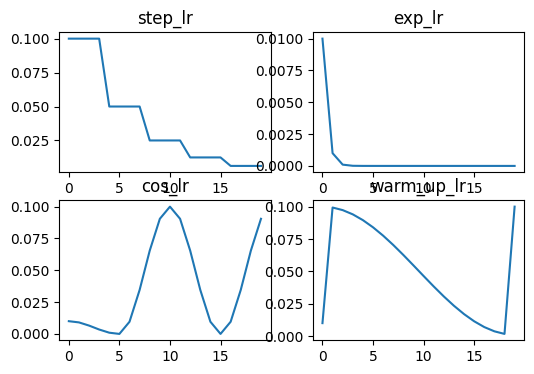

In [35]:
epochs = 20


schedulers = {'step_lr':torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5),
              'exp_lr':torch.optim.lr_scheduler.ExponentialLR(optimizer,  gamma=0.1),              
              'cos_lr':torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0),
              'warm_up_lr':torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 
                                                                   T_0=19, T_mult=1, 
                                                                   eta_min=0.001)}

lrs = np.zeros((len(schedulers), epochs))
fig, axs = plt.subplots(2,2,figsize=(6,4));

with torch.inference_mode():
     
    for j, (k,scheduler) in enumerate(zip(schedulers.keys(), schedulers.values())):

        for i in range(epochs):
            optimizer.step()
            lrs[j,i] = optimizer.param_groups[0]["lr"]
            scheduler.step()
        optimizer.param_groups[0]["lr"]  = 0.01
        axs.ravel()[j].plot(range(epochs),lrs[j]); 
        axs.ravel()[j].set_title(k);


<blockquote>
    
Отметим, что также может быть использован планировщик `ReduceLROnPlateau`, который снижает скорость обучения автоматически при выходе валидации на плато.
    
```python

    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    scheduler = ReduceLROnPlateau(optimizer, 'min')
    for epoch in range(10):
        train(...)
        val_loss = validate(...)
        # Note that step should be called after validate()
        scheduler.step(val_loss)
```

Дополним функцию тренировки новым аргументом `scheduler`.

In [36]:
def train(model, dataloader, optimizer, criterion, metric, scheduler=None,  device = 'cpu'):

    epoch_loss = 0
    epoch_acc  = 0

    model.train()

    for (x, y) in tqdm(dataloader, desc="Training", leave=False):

        x, y = x.to(device), y.to(device)

        optimizer.zero_grad(set_to_none = True)

        y_pred = model(x)

        loss = criterion(y_pred, y)
        acc  = metric( y_pred, y)

        loss.backward()
        
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1., norm_type= 2)
        
        optimizer.step()                

        epoch_loss += loss.item()
        epoch_acc  += acc.item()
    
    if scheduler != None:
        scheduler.step()
        
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

Проверим работу расписания. 

Следует также отметить, что помимо расписания ниже приведен следующий код:
```python
    max_grad = 10
    for p in model.parameters():
        p.register_hook(lambda grad: torch.clamp(grad, -0.1, max_grad))
```

Такой прием позволяет ограничить значение градиента (`gradient clipping`): `lambda grad: torch.clamp(grad, -0.1, max_grad)`. Прием применяется для всех параметров, так как задан цикл. При этом данный прием записывается как дополнительная функция при расчете градиента. Это реализовано через т.н. `hook`. По средствам метода `register_hook` подобно `callback` каждому параметру ставится дополнительная функция в соответствие.

Отметим, что можно бы было провести `gradient clipping` при помощи встроенной утилиты `torch.nn.utils.clip_grad_norm_`. В функции `train` выше эта строка закомментирована. 

In [37]:
LR_PERIOD = 2
LR_DECAY  = 0.9
LR = 0.1;


model = Model()
model = model.to(device)
criterion = criterion.to(device)

model.apply(initialize_parameters)

max_grad = 10
for p in model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -0.1, max_grad))

optimizer = optim.Adam(model.parameters(), lr=LR)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size = LR_PERIOD, 
                                            gamma     = LR_DECAY)


In [38]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, metric, scheduler)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, metric, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s | LR {optimizer.param_groups[0]["lr"] :.4f}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%',
    f' | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 4s | LR 0.1000
	Train Loss: 0.812 | Train Acc: 70.23%  | Val. Loss: 0.736 | Val. Acc: 74.33%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 4s | LR 0.0900
	Train Loss: 0.764 | Train Acc: 72.90%  | Val. Loss: 0.800 | Val. Acc: 72.27%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 4s | LR 0.0900
	Train Loss: 0.725 | Train Acc: 74.30%  | Val. Loss: 0.700 | Val. Acc: 74.25%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 4s | LR 0.0810
	Train Loss: 0.666 | Train Acc: 76.91%  | Val. Loss: 0.658 | Val. Acc: 77.49%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 4s | LR 0.0810
	Train Loss: 0.633 | Train Acc: 78.01%  | Val. Loss: 0.660 | Val. Acc: 78.66%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 4s | LR 0.0729
	Train Loss: 0.613 | Train Acc: 78.84%  | Val. Loss: 0.618 | Val. Acc: 79.24%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 4s | LR 0.0729
	Train Loss: 0.601 | Train Acc: 79.07%  | Val. Loss: 0.622 | Val. Acc: 79.72%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 4s | LR 0.0656
	Train Loss: 0.618 | Train Acc: 78.54%  | Val. Loss: 0.606 | Val. Acc: 80.41%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 4s | LR 0.0656
	Train Loss: 0.594 | Train Acc: 79.79%  | Val. Loss: 0.660 | Val. Acc: 78.81%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 4s | LR 0.0590
	Train Loss: 0.593 | Train Acc: 79.86%  | Val. Loss: 0.595 | Val. Acc: 80.03%


In [39]:
test_loss, test_acc = evaluate(model, test_loader, criterion, metric, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.602 | Test Acc: 79.40%


<!-- https://pytorch.org/vision/main/auto_examples/transforms/plot_cutmix_mixup.html#sphx-glr-auto-examples-transforms-plot-cutmix-mixup-py
from torchvision.transforms import v2
NUM_CLASSES = 10
alpha  = 0.5

cutmix = v2.CutMix(num_classes=NUM_CLASSES, alpha = alpha)
mixup = v2.MixUp(num_classes=NUM_CLASSES, alpha = alpha)
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

for images, labels in train_loader:
    images = images.reshape(-1,1,28,28)
    print(f"Before CutMix/MixUp: {images.shape = }, {labels.shape = }")
    images, labels = cutmix_or_mixup(images, labels)
    print(f"After  CutMix/MixUp: {images.shape = }, {labels.shape = }")
    
    targets1, targets2 = 
    loss = alpha * criterion(preds, targets1) + (1 - self.alpha) * criterion(preds, targets2)

    break
    
targets = torch.nonzero(labels).reshape(-1,4)[:,1::2]
    
images = images.reshape(-1,1,28,28)
batch = torchvision.utils.make_grid(images, nrow = int(np.sqrt(images.shape[0])), padding = 0)
vis_batch = batch.data.numpy().transpose((1, 2, 0))*255
plt.imshow(vis_batch); 
plt.axis('off');
plt.show()
images.shape, batch.shape,  vis_batch.shape  

class CutMixCELoss(nn.Module):
    def __init__(self, alpha = 0.5):
        super(CutMixCELoss, self).__init__() 
        self.criterion = nn.CrossEntropyLoss
        self.alpha = alpha

    def farward(self, preds, targets):
        targets1, targets2  = targets
        return self.alpha * self.criterion(preds, targets1)\
            + (1 - self.alpha) * self.criterion(preds, targets2)
            
```python
    from torch.utils.data import default_collate

    def collate_fn(batch):
        return cutmix_or_mixup(*default_collate(batch))
    
    
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn) -->

## Задания

__1.__ Предлагается описать архитектуру GeLU MLP (в изначальном примере) в виде блока экстрактора признаков и головной части.

__2.__ Предлагается проверить возможность оптимизации архитектуры при выборе не одинаковых скоростей обучения для головной части и части кодировщика признаков

<code style="color : red">__3.*__</code> Проверьте, как влияют те или иные режимы инициализации на качество работы нейронной сети. Например, инициализация постоянными величинами `nn.init.constant_(m.weight, constant_weight)`.

<code style="color : red">__4.*__</code> В ряде [случаев](https://discuss.pytorch.org/t/tricks-for-being-able-to-use-a-higher-learning-rate/142179) рекомендуется стратегия обучения, когда изначально используется крайне низкая скорость обучения в течение нескольких эпох, чтобы веса модели настроились в нужном направлении. Такие эпохи будут сравнительно бесполезными с точки зрения результата обучения, но повышают стабильность экспериментов. Затем скорость обучения резко увеличивают и начинают плавно снижать. Предполагается, что после первоначальной настройки весов они могут быстро обучиться в нужном направлении. __Предлагается__ реализовать эту стратегию самостоятельно.

<code style="color : red">__5.*__</code> Часто предпочтительно использовать предобученный кодировщик признаков одной сети ка основу для другой. Предлагается собрать архитектуру на основе обученной GeLU MLP с новой головной частью и проверить ее производительность. При этом скорость обучения для кодировщика признаков рекомендуется понзиить.

# Анализ ошибок в наборе данных

Часто, помимо того, чтобы просто провести точечную оценку точности, необходимо понять причины ошибок. Для этого полезно провести анализ ошибок на тестовой выборке. Как минимум для задачи классификации можно провести анализ точности по классам.

In [103]:
correct = 0
total   = 0

n_classes = 10
class_correct = torch.zeros(n_classes)
class_total   = torch.zeros(n_classes)

model.eval()
with torch.no_grad():
    for x, y  in test_loader:
 
        output = model(x.view(-1,784))
        cls_pred = torch.argmax(output, dim=1)
        
        for idx, (yi, y_hat) in enumerate(zip(y,cls_pred)):

            if y_hat == yi:
                class_correct[yi] += 1
            
            class_total[yi]   += 1


for i in range(n_classes):
    print('Accuracy of %5s : %2d %%' % (
        i, 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 71 %
Accuracy of     1 : 93 %
Accuracy of     2 : 66 %
Accuracy of     3 : 82 %
Accuracy of     4 : 74 %
Accuracy of     5 : 93 %
Accuracy of     6 : 63 %
Accuracy of     7 : 93 %
Accuracy of     8 : 95 %
Accuracy of     9 : 89 %


Также проведем визуализацию ошибок путем построения матрицы ошибок.

In [104]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(labels, pred_labels, names_classes = np.arange(10)):
    
    fig, ax = plt.subplots(figsize=(6, 6))
    
    cm = confusion_matrix(np.asarray(labels, dtype=int), 
                          np.asarray(pred_labels, dtype=int) )
    
    cm = ConfusionMatrixDisplay(cm, display_labels=names_classes)
    
    cm.plot(values_format='d', cmap='coolwarm', ax=ax)

Теперь соберем лейблы и предсказания в отдельные массивы.

In [106]:
labels   = []
predicts = []

model.eval()
with torch.no_grad():
    
    for x,y in test_loader:

        output = model(x.view(-1,784))
        cls_pred = torch.argmax(output, dim=1)
    
        labels.append(y.tolist())
        predicts.append(cls_pred.tolist())
        
labels = sum(labels,[])
predicts = sum(predicts,[])
# labels   = torch.cat(labels, dim = 0) # make it 1d array
# predicts = torch.cat(predicts, dim = 0) # make it 1d array
    


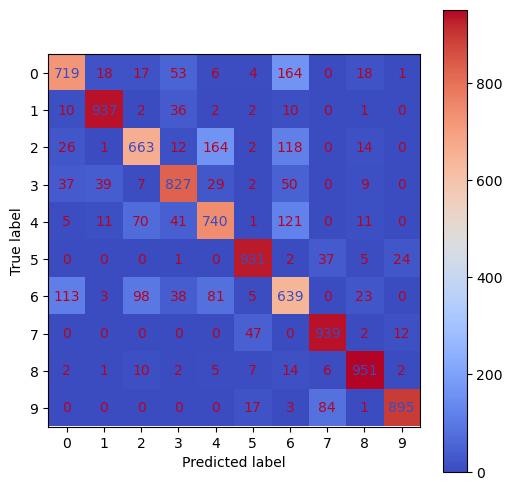

In [107]:
plot_confusion_matrix(labels, predicts)

## Задание

__1.__ Предлагается проверить `scores`, помимо самих результатов.

<code style="color : red">__2.*__</code>  Важно проверить, в каких примерах ваша модель ошибается, и убедиться, что это разумные ошибки.

Ниже приведен пример того как это сделать.
Функция `get_predictions` возвращает предсказания модели для заданного набора данных. Она возвращает входные данные (изображение), выходные данные (предсказания модели) и метки истинности. Также код ниже рассчитывает `pred_labels` - предсказанные метки класса.

In [110]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs  = []

    with torch.inference_mode():

        for (x, y) in iterator:

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

images, labels, probs = get_predictions(model, test_loader)

pred_labels = torch.argmax(probs, 1)

Теперь проверим полученные метки на корректность.

In [111]:
corrects = torch.eq(labels, pred_labels)

Можно просмотреть все примеры предсказаний модели и сохранить в массив все примеры, в которых модель ошиблась.

Затем мы отсортируем неправильные примеры по степени уверенности в них, причем самые уверенные будут стоять на первом месте.

In [112]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)

Визуализируем 25 самых неверных примеров. К каждому из них будет показан уровень уверенности и метка.

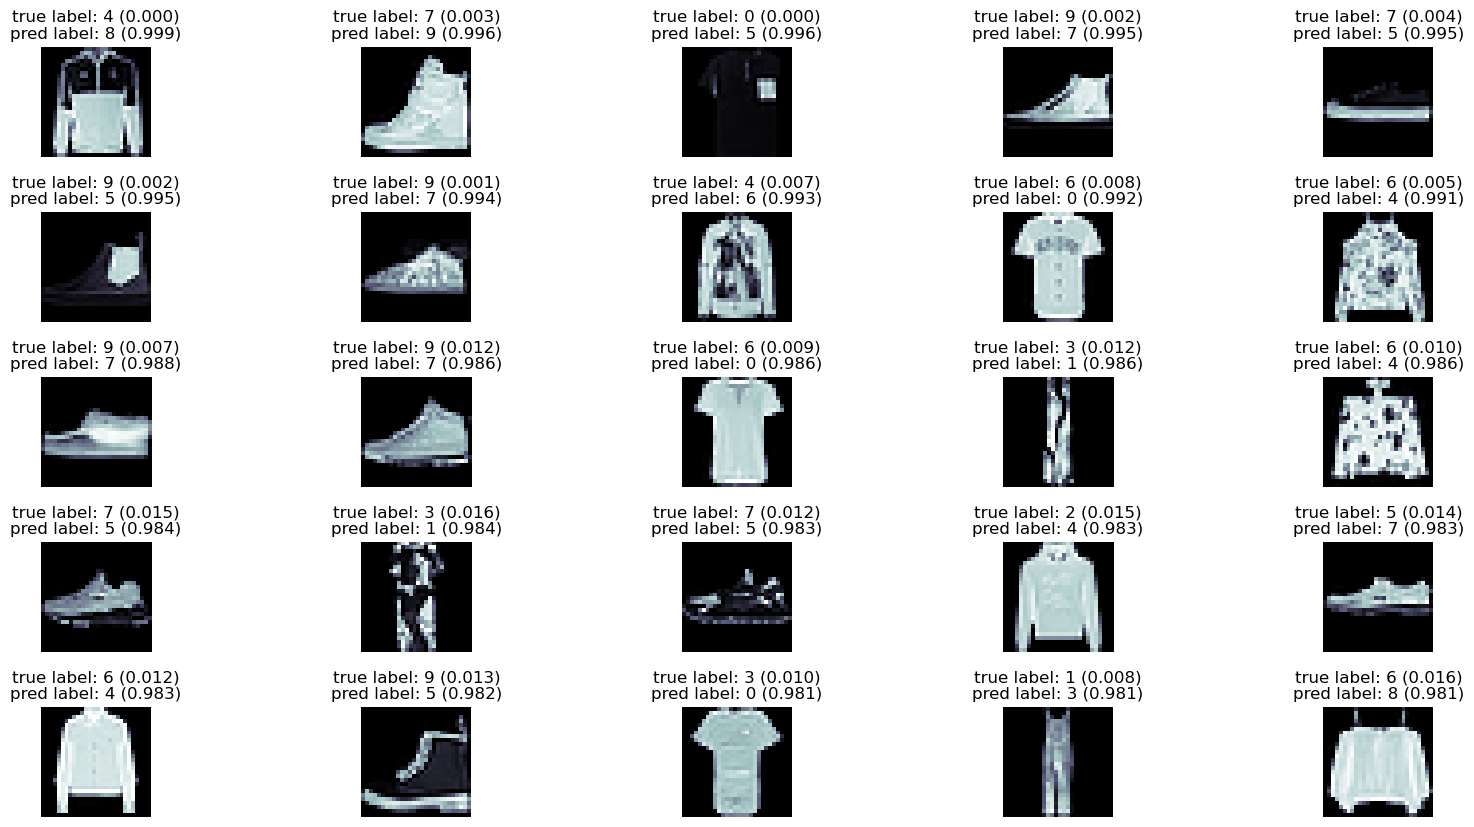

In [113]:
def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)

Визуализированы только 25 результатов. __Предлагается__ провести анализ неточности по каждому классу отдельно если задан порог или число наиболее неточных результатов (аналогично анализу по каждому классу выше, но для заданного числа наиболее плохих результатов модели). Также предлагаем подумать слушателю какие методы позволили бы улучшить точность.

<code style="color : red">__3.*__</code> Иногда полезно посмотреть, как модель отображает классы в результате работы `feature extractor` (`backbone`). Этот прием используется в нескольких целях, например, позволяет визуализировать отображение классов нейронной сетью. Для того чтобы такой прием реализовать, необходимо иногда возвращать результат работы последнего слоя `feature extractor` отдельным выходом нейронной сети. Предлагается слушателю самостоятельно реализовать эту опцию, например, при помощи объявления дополнительного аргумента `ret_fe` метода `forward`.

<details>
    
<!-- <summary>Click here for hint</summary> -->
```python
    
    IMAGE_WIDTH = 28 
    IMAGE_HEIGH = 28
    
    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(IMAGE_WIDTH*IMAGE_HEIGH, 64)
            self.fc2 = nn.Linear(64, 64)
            self.fc3 = nn.Linear(64, 10)

    
        def forward(self, x, ret_fe = False):
            x = F.relu(self.fc1(x))
            h = F.relu(self.fc2(x))
            x = self.fc3(h)

            if ret_fe:
                return x, h
            return x  #log(softmax(x)) in loss assumed
    
```

<code style="color : red">__4.*__</code> Ниже приведен пример реализации оценки с использованием дополнительного выхода `intermediates` - выхода представления признаков моделью.

In [115]:
def get_representations(model, iterator):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():

        for (x, y) in iterator:

            y_pred, h = model(x, ret_fe = True)

            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    intermediates = torch.cat(intermediates, dim=0)
    labels = torch.cat(labels, dim=0)

    return outputs, intermediates, labels

outputs, intermediates, labels = get_representations(model,
                                                     train_loader)

TypeError: Model.forward() got an unexpected keyword argument 'ret_fe'

Теперь проведем визуализацию полученных результатов методом главных компонент.

In [116]:
from sklearn import decomposition
from sklearn import manifold
def get_pca(data, n_components=2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [117]:
def plot_representations(data, labels, n_images=None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10')
    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=labels)

In [118]:
intermediate_pca_data = get_pca(intermediates)
plot_representations(intermediate_pca_data, labels)

NameError: name 'intermediates' is not defined

Ниже также показан пример визуализации методом `t_sne`.

In [119]:
def get_tsne(data, n_components=2, n_images=None):
    if n_images is not None:
        data = data[:n_images]
    tsne = manifold.TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

In [120]:
N_IMAGES = 5_000

intermediates_tsne_data = get_tsne(intermediates, n_images=N_IMAGES)
plot_representations(intermediates_tsne_data, labels, n_images=N_IMAGES)

NameError: name 'intermediates' is not defined

__Предлагается__ проверить визуально качество сепарации данных и качество работы модели в целом в зависимости от сложности модели (например, числа слоев в ней или использования дополнительных параметров, таких как функции активации или применение регуляризаций (батч-норм, аугментация и т.д.).

<code style="color : red">__5.*__</code> Предлагается провести визуализацию выходов модели и сравнить ее с визуализацией промежуточных результатов. <br> Если допустить, что промежуточные результаты должны исходить не из последнего скрытого слоя, а из более ранних слоев, как это скажется на визуализации?

<code style="color : red">__6.*__</code> Также для оценки надежности модели можно проверить ее работу для шумов. Проверим, что для обученной модели можно создать такое распределение нормального шума на входе, что ее выход будет классифицирован как заданное верное число с определенной долей уверенности.

In [121]:
from tqdm.notebook import trange

def imagine_digit(model, digit, n_iterations=5_000):

    model.eval()

    best_prob = 0
    best_image = None

    with torch.no_grad():

        for _ in trange(n_iterations):

            x = torch.randn(BATCH_SIZE, 28, 28).reshape(BATCH_SIZE, 28*28)

            y_pred = model(x)

            preds = F.softmax(y_pred, dim=-1)

            _best_prob, index = torch.max(preds[:, digit], dim=0)

            if _best_prob > best_prob:
                best_prob = _best_prob
                best_image = x[index]

    return best_image, best_prob

In [122]:
DIGIT = 0

best_image, best_prob = imagine_digit(model, DIGIT)

  0%|          | 0/50000 [00:00<?, ?it/s]

Best image probability: 100.00%


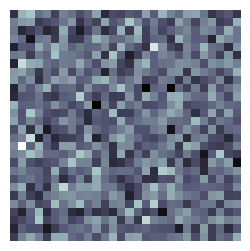

In [123]:
print(f'Best image probability: {best_prob.item()*100:.2f}%')

plt.figure(figsize=(3,3)); plt.imshow(best_image.cpu().numpy().reshape(28,28), cmap='bone')
plt.axis('off');

__Предлгагаем__ проверить то, как аугментация данных влияет не вероятность правильной классификации выборки нормального шума.

>Также __предлагаем__ провести анализ "на ошибки" результатов генерации шумовых изображений.